# **Sentiment analysis of youtube comments**

## **Introduction**

In this work, simple natural language processing (nlp) techniques are used to derive a model for sentiment analysis of youtube comments. A Kaggle dataset of youtube comments is used to train and validate the model. The dataset contains two columns, one is the comment text and the order is the sentiment classified in "positive", "negative" or "neutral".

## **Importing libraries**

In [25]:
import pandas as pd
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from textblob import TextBlob
from xgboost import XGBClassifier
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## **Functions**

In [26]:
# cleans text
def text_cleaning(text):
    doc = nlp(text)
    cleaned_text = ' '.join([token.lemma_ for token in doc]) # lemmatization
    cleaned_text = re.sub(r'([^\s\w]|_)+', ' ', cleaned_text) # keeps only letters and numbers

    # reduces multiple space to a single space and removes spaces at the beggining and at the end of the text 
    return re.sub(r'\s+', ' ', cleaned_text).strip() 

In [27]:
# computes evaluation metrics
def creates_metrics_table(df_pred_actual, X_pred, models):    
    accuracy, f1, auc = [], [], []
    
    for m in models.items():
        
        accuracy.append(accuracy_score(df_pred_actual['actual'], df_pred_actual[m[0]]))
        f1.append(f1_score(df_pred_actual['actual'], df_pred_actual[m[0]]))
        auc.append(roc_auc_score(df_pred_actual['actual'], m[1].predict_proba(X_pred)[:, 1]))
        
    return pd.DataFrame({'Accuracy' : accuracy, 'F1-Score' : f1, 'AUC' : auc}, index=models.keys())

In [28]:
# creates a dataframe containing features and their coefficients in a logistic model
def creates_features_coefficients_table(model, tfidf_model):
    coefficients = model.coef_[0]
    df_output = pd.DataFrame({'Feature': sorted(tfidf_model.vocabulary_), 'Coefficient': coefficients})

    return df_output.sort_values('Coefficient')

In [29]:
# colors words according to the positive or negative effect
def make_color_func(df):
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        if df.loc[df['Feature'] == word, 'Coefficient'].values[0] > 0:
            return 'blue'  # positive words in blue
        else:
            return 'red'  # negative words in red
    return color_func

In [30]:
# builds the wordcloud
def builds_wordcloud(df_input):
    word_coeff = dict(zip(df_input['Feature'], abs(df_input['Coefficient'])))
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='coolwarm').generate_from_frequencies(word_coeff)

    # creates the color function dynamically
    color_func_with_df = make_color_func(df_input)

    # applies the custom coloring
    wordcloud.recolor(color_func=color_func_with_df)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

## **Loading the dataset** 

In [31]:
# loads the dataset 
df = pd.read_csv('YoutubeCommentsDataSet.csv')
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [32]:
# checks the size of the different classes
df.Sentiment.value_counts()

Sentiment
positive    11432
neutral      4638
negative     2338
Name: count, dtype: int64

Verificando a presença de dados faltantes

In [33]:
# verifica a existência de dados faltantes nas colunas
print('Dados faltantes:')
print(df.isna().sum())

Dados faltantes:
Comment      44
Sentiment     0
dtype: int64


In [34]:
# remove as linhas sem comentários
df = df.loc[~df.Comment.isna()]

## **Data cleaning**

In [35]:
# adds a new column with cleaned text
df['cleaned_comment'] = df['Comment'].apply(text_cleaning)

In [36]:
# the new dataset
df.head()

,Comment,Sentiment,cleaned_comment
0,lets not forget that apple pay in 2014 require...,neutral,lets not forget that apple pay in 2014 require...
1,here in nz 50 of retailers don’t even have con...,negative,here in nz 50 of retailer do not even have con...
2,i will forever acknowledge this channel with t...,positive,I will forever acknowledge this channel with t...
3,whenever i go to a place that doesn’t take app...,negative,whenever I go to a place that do not take appl...
4,apple pay is so convenient secure and easy to ...,positive,apple pay be so convenient secure and easy to ...


Only "positive" and "negative" sentiments will be considered in the analysis

In [37]:
# removes neutral comments
df = df.loc[~(df.Sentiment == 'neutral')]

# transforms target to numeric
df['Sentiment'] = df['Sentiment'].map({'positive' : 1, 'negative' : 0})

## **Training machine learning models**

### Train-test split

In [38]:
# divides texts and target
X, y = df['cleaned_comment'], df['Sentiment']

# splits data into train and test partitions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

### Transforming text into vector

Here, texts are transformed into vectors using tf-idf.

In [39]:
# text to vector transformation using tf-idf
tfidf_model = TfidfVectorizer(max_features=500)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(X_train).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)

tfidf_df.head()

,10,able,about,absolutely,actually,add,advice,after,again,ago,...,wrong,xbox,year,yes,yet,you,young,your,yourself,youtube
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0
2,0.0,0.096511,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.168039,0.0,0.00000,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.203198,0.0,0.00000,0.0,0.0
4,0.0,0.000000,0.109835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.139383,0.0,0.09696,0.0,0.0


### Fitting models

In [40]:
# list of models
models = {'logreg' : LogisticRegression(), 'xgboost' : XGBClassifier()}

In [41]:
# fits models
for m in models.items():
    m[1].fit(tfidf_df,y_train)

### Testing models

In [42]:
# transform text to vector of testing dataset
tfidf_df_predict = pd.DataFrame(tfidf_model.transform(X_test).todense())
tfidf_df_predict.columns = sorted(tfidf_model.vocabulary_)

In [43]:
# making predictions

# initializes de prediction versus actual dataframe
pred_vs_real = pd.DataFrame({'actual' : y_test})

for m in models.items():
    predicted_labels = m[1].predict(tfidf_df_predict)
    pred_vs_real[m[0]] = predicted_labels

pred_vs_real.head()

,actual,logreg,xgboost
8205,1,1,1
11293,1,1,1
12284,0,0,0
17858,1,1,1
11456,1,1,1


### Computing evaluation metrics

In [44]:
# computes evaluation metrics
metrics = creates_metrics_table(pred_vs_real, tfidf_df_predict, models)
metrics

,Accuracy,F1-Score,AUC
logreg,0.867904,0.924517,0.895292
xgboost,0.872635,0.926440,0.894187


## Word cloud of terms importance

In [45]:
# creates a dataframe containing words and their coefficients in the logistic model
coef_df = creates_features_coefficients_table(list(models.values())[0], tfidf_model)
coef_df

,Feature,Coefficient
291,not,-3.969658
37,bad,-3.293470
250,lose,-3.278571
490,wrong,-2.911016
475,why,-2.809547
...,...,...
168,great,5.081069
17,amazing,5.179355
166,good,5.214803
419,thank,5.631776


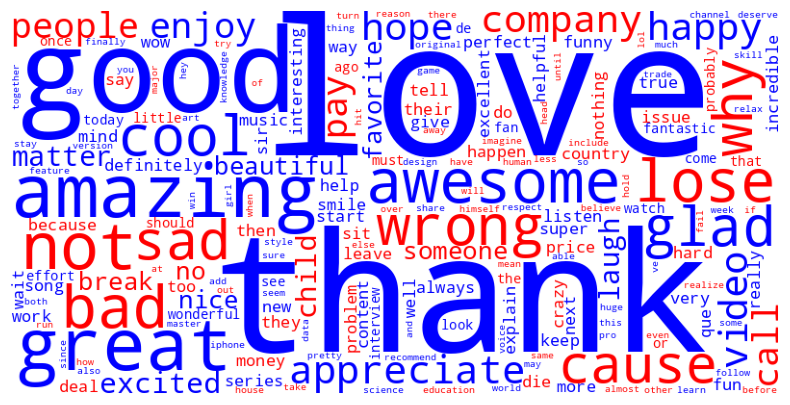

In [46]:
# builds the word cloud
builds_wordcloud(coef_df)